# Libraries

In [1]:
from mnist import MNIST
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, '../../Libraries')
import JacksonsTSPackage as jts
from ltar import LTAR
from statsmodels.tsa.api import VAR

# Loading and Organizing the Data

In [2]:
mndata = MNIST('./Data')
images, labels = mndata.load_training()
labels = labels.tolist()

In [3]:
# Organizing the data
images = [x for _,x in sorted(zip(labels,images))]
labels.sort()
label_counts = list(Counter(labels).values())
num_cycles = min(label_counts)

tensor_shape = (num_cycles*10, 28, 28)
data = np.empty(tensor_shape)

# Makes the cycle
for i in range(num_cycles):
    for j in range(10):
        offset = sum(label_counts[:j]) + i
        tmp = np.asarray(images[offset])
        tmp.resize((tensor_shape[1], tensor_shape[2]))
        data[i*10 + j] = tmp

In [4]:
N = len(data)
N_train = 48780
N_test = N - N_train
print(f"N: {N}")
print(f"N_train: {N_train}")
print(f"N_test: {N_test}")

N: 54210
N_train: 48780
N_test: 5430


In [5]:
train_tensor = jts.extract_train_tensor(data, N_train)
train_tensor

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

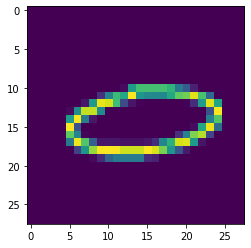

In [6]:
plt.imshow(train_tensor[0])

In [7]:
test_tensor = jts.extract_test_tensor(data, N_train, N_test)
test_tensor

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [21]:
ltar = LTAR(train_tensor)
ltar.fit(10)

In [22]:
result_tensor = ltar.forecast(10)

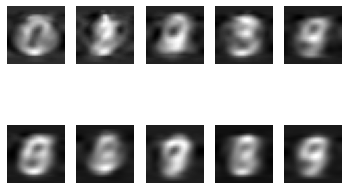

In [23]:
jts.implot_tensor(result_tensor, (2, 5))

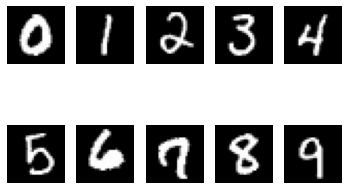

In [24]:
jts.implot_tensor(test_tensor, (2, 5))